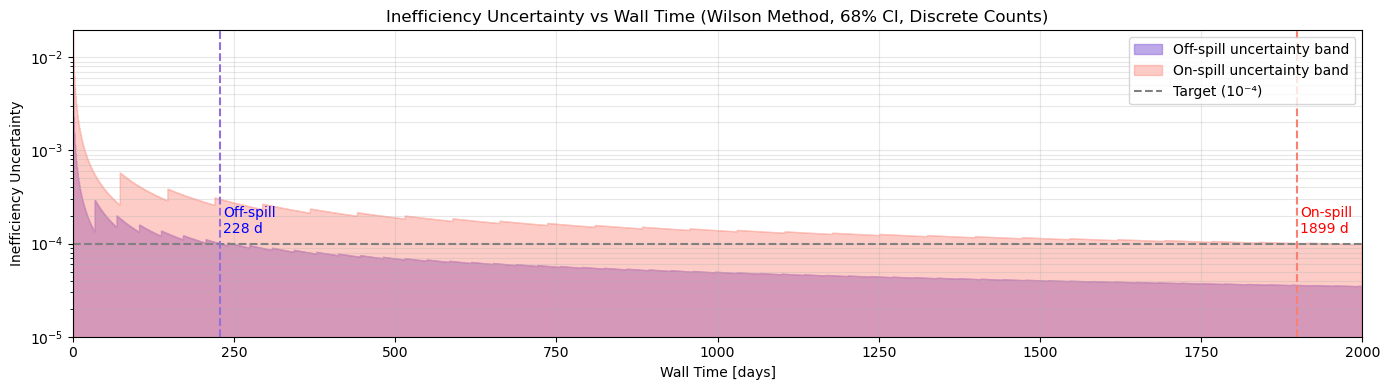

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

# Wilson uncertainty (half-width) function
def wilson(k, N, z=1.0):  # 68% confidence ⇒ z = 1.0
    alpha = 2 * (1 - norm.cdf(z))
    lower, upper = proportion_confint(k, N, alpha=alpha, method="wilson")
    return (upper - lower) / 2

# Get first time when uncertainty hits target
def get_target_time(t, unc, target=1e-4):
    for i, val in enumerate(unc):
        if np.isnan(val) or val <= 0:
            continue
        if val <= target:
            return t[i]
    return np.nan

# Constants
live_time_sec = 1.06887e7
livetime_days = live_time_sec / (24 * 3600)

N_b_off, N_ce_off = 5, 18914
N_b_on,  N_ce_on  = 6, 11693

# Rates [events per live-day]
rate_b_off = N_b_off / livetime_days
rate_ce_off = N_ce_off / livetime_days
rate_b_on  = N_b_on  / livetime_days
rate_ce_on  = N_ce_on  / livetime_days

# Wall time range [0–2000 days]
t_wall = np.arange(0, 2001, 1)

# Convert wall time → live time
t_live_off = t_wall * 0.72
t_live_on  = t_wall * 0.28

# Discrete, integer counts
N_b_off_t = np.floor(t_live_off * rate_b_off).astype(int)
N_ce_off_t = np.floor(t_live_off * rate_ce_off).astype(int)
N_b_on_t  = np.floor(t_live_on * rate_b_on).astype(int)
N_ce_on_t  = np.floor(t_live_on * rate_ce_on).astype(int)

# Wilson uncertainties (68% CI ⇒ z=1.0)
unc_off = np.array([wilson(k, N, z=1.0) for k, N in zip(N_b_off_t, N_ce_off_t)])
unc_on  = np.array([wilson(k, N, z=1.0) for k, N in zip(N_b_on_t, N_ce_on_t)])

# Target crossing
target = 1e-4
t_off_target = get_target_time(t_wall, unc_off, target)
t_on_target  = get_target_time(t_wall,  unc_on,  target)

# Plot
fig, ax = plt.subplots(figsize=(14, 4))

# Fill uncertainty bands
ax.fill_between(t_wall, 0, unc_off, color='mediumpurple', alpha=0.6, step='mid', label="Off-spill uncertainty band")
ax.fill_between(t_wall, 0, unc_on, color='salmon', alpha=0.4, step='mid', label="On-spill uncertainty band")

# Horizontal target line
ax.axhline(target, color='gray', linestyle='--', label="Target (10⁻⁴)")

# Vertical target lines
if not np.isnan(t_off_target):
    ax.axvline(t_off_target, color='mediumpurple', linestyle='--')
    ax.text(t_off_target + 5, target*1.3, f"Off-spill\n{int(t_off_target)} d", color='blue')

if not np.isnan(t_on_target):
    ax.axvline(t_on_target, color='salmon', linestyle='--')
    ax.text(t_on_target + 5, target*1.3, f"On-spill\n{int(t_on_target)} d", color='red')

# Formatting
ax.set_xlim(0, 2000)
ax.set_ylim(bottom=1e-5)
ax.set_yscale('log')
ax.set_xlabel("Wall Time [days]")
ax.set_ylabel("Inefficiency Uncertainty")
ax.set_title("Inefficiency Uncertainty vs Wall Time (Wilson Method, 68% CI, Discrete Counts)")
ax.legend(loc='upper right')
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()